# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Read in file
data = pd.io.stata.read_stata('us_job_market_discrimination.dta')

In [3]:
# Determine number of callbacks for white-sounding names (For general reference)
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


# Q1:  What test is appropriate for this problem? Does the CLT apply?

For this problem, we want to see if each group, the 'b' and 'w' sounding resumes, yeild similar successful (p) returns toward a call. Since we have two groups and want to see if they are treated equally, I am going to use a permutation test. The CLT applies in this situation since we are assuming that each entry of 'b' or 'w' is independently assigned (from the identical resumes) and we would expect an approximate normal distribution of sample mean results from this data.

# Q2: What are the null and alternate hypotheses?

Suppose p represents the probability of successfully getting a call back from a resume, where 1 is a success and 0 is a failure. Both the black and white distributions of this "call" should follow a Bernouli distribution, as there is a p rate for success and q or (1-p) rate for failure. The null hypothesis (assuming there is no bias between the two) is that the two data sets have identical values of p. That being said, their difference should equate to 0 in our null hypothesis. The alternative hypothesis is that the difference of these values exceeds 0. These hypotheses are denoted below: 
<br>
<br>
<center>$H_{0}$: $p_{w}$ - $p_{b}$ = 0</center>
<center>$H_{a}$: $p_{w}$ - $p_{b}$ > 0</center>

# Q3: Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

In [5]:
# Define parts of list that are white- or black-sounding: w, b
w = data[data.race=='w']
b = data[data.race=='b']

In [6]:
# Determine sample proportion of successfully returned calls with white-sounding names: w_rate
w_returns = w.call.sum()
w_attempts = w.call.count()
w_rate = w_returns/w_attempts

print(w_rate)

0.09650924024640657


In [7]:
# Determine sample proportion of returned calls with black-sounding names: b_rate
b_returns = b.call.sum()
b_attempts = b.call.count()
b_rate = b_returns/b_attempts

print(b_rate)

0.06447638603696099


## Part 1: Bootstrap Approach

We will use a bootstrap method to collect data and perform a hypothesis test. This essentially draws small sample sets (with replacement) from within the sample data, and calculates the mean difference of success rates between white- and black-sounding names ($p_{w}$ - $p_{b}$). By plotting these results, we can determine the p% confidence interval of our observed test statistic.

In [8]:
# Reconstruct column 'race' to be boolean, where w = 1, b = 0
def boolean_race(row):
    if row['race'] == 'w':
        return 1
    return 0

In [9]:
# Apply function to race column, save as a dataframe: bool_race
res = data.apply(boolean_race, axis=1)
bool_race = res.to_frame('bool_race')

In [10]:
# Add bool_race column to original dataframe and select pertinent columns: call_race_data
new_data = pd.concat([data, bool_race], axis=1)
call_race_data = new_data[['call', 'bool_race']]
call_race_data.head()

,call,bool_race
0,0.0,1
1,0.0,1
2,0.0,0
3,0.0,0
4,0.0,1


In [11]:
# Define data of interest and turn to arrays: call, race
call = call_race_data['call'].values
race = call_race_data['bool_race'].values

Since these columns, 'call' and 'bool_race', are dependent on each other, we have to use a pair-wise bootstrap method. This will sample the data in pairs and compute the slope and intercept from the sampled data. From there, we can compute p-values and confidence intervals for both our slope and intercept values.

In [12]:
# Define how we draw bootstrap pairs
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))
    
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [13]:
# Draw sample of 1000 pairs
pair_slope, pair_intercept = draw_bs_pairs_linreg(call, race, size=1000)

Plot the first 200 bootstrap pairs and visualize the linear relationships

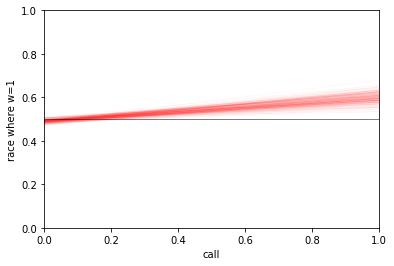

In [14]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 200])

# Plot the bootstrap lines
for i in range(200):
    plt.plot(x, pair_slope[i]*x + pair_intercept[i],
                 linewidth=0.5, alpha=0.05, color='red')

# Label axes, set the margins, and show plot of bootstrap pairs
plt.xlabel('call')
plt.ylabel('race where w=1')
plt.xlim([0,1])
plt.ylim([0,1])
plt.margins(0.02)

# Insert "non-biased" line where success rate is constant 0.5
plt.axhline(y=0.5, color='black', linewidth=0.5)

plt.show()

In our null hypothesis where there is no bias, we assert that both success rates are identicalfor each race. Visually, this is represented in the black "non-biased" line above, a horizantal line at 0.5. It is clear that of our first 200 results, the trend seems not to match this horizantal line.
<br>
<br>
The pairs_slope data itself represent the difference between $p_{w}$ and $p_{b}$, in which a positive slope value reflects bias toward $p_{w}$ and a negative value reflects bias toward $p_{b}$. Now, we will compute the p-value and confidence interval of the slopes from our bootstrap pairs to assess if the call response is bias and see how closely this aligns.
<br>
<br>
The p-value is the fraction of the simulated data sets for which the test statistic is at least as extreme as for the true data, denoted below:
<br>
<br>
<center><i>p = ($\sum$ pair_slope <= 0) - 0 / # observations</i></center> 

In [15]:
# Compute p-value for slope values: p
p = (np.sum(pair_slope <= 0)-0)/len(pair_slope)
print('p-value = ', p)

p-value =  0.0


In [16]:
# Compute 99% confidence interval for slope values: CI
CI = np.percentile(pair_slope, [0.5, 99.5])
print('CI ranges ', CI)

CI ranges  [0.04609863 0.18081716]


In summary, there is a 99% chance that we captured the true data slope value within the confidence interval range from 0.041 to 0.185. Since this range does not include our null hypothesis value of 0, our p-value is also 0. This means that from our data set, we can successfully reject the null hypothesis that the true rate of successes in resume callbacks is non-biased. From our compelling results, our data suggests that there is a bias here, preferring the white-sounding resume names over the black-sounding ones.

## Part 2: Frequentist Approach

For this approach, we will perform a permutation hypothesis test. To do this, we will take 1,000 permutation samples. Each sample will include the following procedure. 
<br>
<br>
Take the original data and permute (shuffle) the entries in the 'call' column. Then, assign the first half to be "white-sounding" and the second to be "black-sounding." We will then split the data into permuted samples: perm_w and perm_b. Plot each difference of means of those two values 1,000 times in a histogram. Finally, we will see how extreme our observed sample data value is in relation to this distribution of permutation tests.

In [17]:
# Write a script that calculates permuted data mean differences

# Initialize empty array of replicates
perm_reps = np.empty(1000)

# Establish random seed for reproducability
np.random.seed(42)

# Draw replicates
for i in range(1000):
    # Permute call_data
    if i <= 1:
        permuted_data = np.random.permutation(call)
        perm_reps[i] = np.mean(permuted_data[:len(w)]) - np.mean(permuted_data[len(w):])
    # Take permutations of most recently permuted data
    else:
        permuted_data = np.random.permutation(permuted_data)
        perm_reps[i] = np.mean(permuted_data[:len(w)]) - np.mean(permuted_data[len(w):])

(array([ 0.88224637,  0.        ,  0.        ,  0.88224637,  0.        ,
         0.        ,  1.76449274,  2.6467391 ,  5.29347821,  2.6467391 ,
         5.29347821,  7.94021731,  2.6467391 , 14.11594189,  5.29347821,
        24.7028983 , 14.11594189, 10.58695642, 43.23007203, 35.28985472,
        27.34963741, 70.57970944, 34.40760835, 77.63768038, 56.46376755,
        42.34782566, 74.10869491, 38.81884019, 44.1123184 , 29.99637651,
        22.93840557, 46.7590575 , 18.52717373, 17.64492736, 36.17210109,
        15.88043462, 13.23369552,  6.17572458,  6.17572458,  9.70471005,
         6.17572458,  2.6467391 ,  1.76449274,  0.        ,  0.88224637,
         1.76449274,  0.88224637,  0.88224637,  0.        ,  0.88224637]),
 array([-0.02874743, -0.02761396, -0.02648049, -0.02534702, -0.02421355,
        -0.02308008, -0.02194661, -0.02081314, -0.01967967, -0.0185462 ,
        -0.01741273, -0.01627926, -0.01514579, -0.01401232, -0.01287885,
        -0.01174538, -0.01061191, -0.00947844, -0

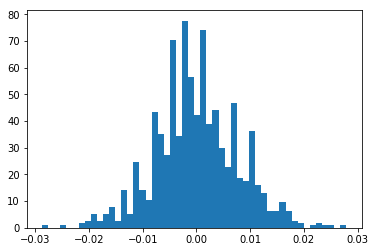

In [18]:
# Plot histogram of array
plt.hist(perm_reps, bins=50, density=True)

In [19]:
# Calculate observed sample mean difference
obs_samp_dif = w_rate - b_rate
print(obs_samp_dif)

0.032032854209445585


In [20]:
# Calculate how many standard deviations our observed value is from the mean
perm_std = np.std(perm_reps)
stds = obs_samp_dif/perm_std

print(stds, ' standard deviations from the mean')

4.140776071270656  standard deviations from the mean


In [21]:
# Calculate p-value of obs_samp_dif
p = (obs_samp_dif - np.mean(perm_reps))/len(perm_reps)
print('p-value = ', p)

p-value =  3.2073100725911725e-05


In conclusion, our observed difference of the mean rates of returned applications between white-sounding and black-sounding resumes was 0.03203. As we drew permutation samples and plotted the histogram of mean differences, we see that this observed value is far from the mean; in fact, this is over 4 standard deviations below what we would expect. This gives us a p-value of 3.207e-05, which is extremely low, guiding us to assess that our observed data does not actually follow a non-biased rate or return of resumes, rejecting our assumed original hypothesis.

## Q4/Q5: Write a story describing the statistical significance in the context or the original problem.  Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?